## Imports

In [9]:
from keras.regularizers import l1_l2
from keras.layers import BatchNormalization
from keras.layers import Bidirectional
from sklearn.utils import shuffle
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.constraints import max_norm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
import tensorflow as tf
from joblib import dump, load
from tensorflow.keras import losses

# Input data

In [10]:
# Load the data
lightCurve = pd.read_csv("/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/lightcurveDataCom7988.csv")
features = pd.read_csv("/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/featureDataCom7988.csv")


# Drop unnecessary columns from the features dataframe
features = features.drop(["simulation_id", 'far', 'snr'], axis=1)

# Filter the light curve data
filtered_df = lightCurve[lightCurve['filter'].isin(['ztfg', 'ztfr', 'ztfi'])].copy()
filtered_df = filtered_df[['filter', 'mag']]

num_light_curves = features.shape[0]

# Ensure the data is in the correct order
filter_order = ['ztfg', 'ztfr', 'ztfi']
filtered_df['filter'] = pd.Categorical(filtered_df['filter'], categories=filter_order, ordered=True)
filtered_df = filtered_df.sort_index()

# Consistency check
total_points = len(filtered_df)
if total_points % (num_light_curves * len(filter_order)) != 0:
    raise ValueError("The number of data points is not divisible by the number of light curves times the number of filters.")

num_time_points = total_points // (num_light_curves * len(filter_order))

# Reshape the data
y = np.empty((num_light_curves, num_time_points * len(filter_order)), dtype=filtered_df['mag'].dtype)
ztfg_mags = filtered_df[filtered_df['filter'] == 'ztfg']['mag'].values.reshape(num_light_curves, num_time_points)
ztfr_mags = filtered_df[filtered_df['filter'] == 'ztfr']['mag'].values.reshape(num_light_curves, num_time_points)
ztfi_mags = filtered_df[filtered_df['filter'] == 'ztfi']['mag'].values.reshape(num_light_curves, num_time_points)

# Populate reshaped array
for i in range(num_time_points):
    y[:, i * 3 + 0] = ztfg_mags[:, i]
    y[:, i * 3 + 1] = ztfr_mags[:, i]
    y[:, i * 3 + 2] = ztfi_mags[:, i]

# Time array
t_min = 0.1
t_max = 14.0
dt = 0.2
time_single = np.linspace(t_min, t_max, num_time_points)

# Standardize the feature data
feature_scaler = StandardScaler()
X = feature_scaler.fit_transform(features)

# Standardize the target data
target_scaler = StandardScaler()
y = target_scaler.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Reshape y data for LSTM input
y_train_reshaped = y_train.reshape((y_train.shape[0], num_time_points, len(filter_order)))
y_test_reshaped = y_test.reshape((y_test.shape[0], num_time_points, len(filter_order)))

# Reshape X data for LSTM input
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Model

In [11]:
# Define the LSTM model
model = Sequential()

# First Bidirectional LSTM Layer with Batch Normalization and Dropout
model.add(Bidirectional(LSTM(150, activation='relu', return_sequences=True,
                             kernel_regularizer=l1_l2(l1=0.001, l2=0.01),
                             kernel_constraint=max_norm(3.0),
                        input_shape=(1, X_train.shape[1]))))
model.add(BatchNormalization())
model.add(Dropout(0.1))

# Second Bidirectional LSTM Layer with Batch Normalization
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=False,
                             kernel_regularizer=l1_l2(l1=0.001, l2=0.01),
                             kernel_constraint=max_norm(3.0)
                             )))
model.add(BatchNormalization())
model.add(Dropout(0.1))

# Dense output layer
model.add(Dense(213))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Training

In [12]:
# Compile the model with a lower learning rate and gradient clipping
optimizer = Adam(learning_rate=0.0003, clipnorm=1.0)  # Only clipnorm is used
model.compile(optimizer=optimizer, loss='mse')

# Implement early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train the model
history = model.fit(X_train_reshaped, y_train, 
                    epochs=300, batch_size=64, validation_split=0.3, 
                    verbose=1, callbacks=[early_stopping, lr_reduction])

# Save the trained model
#dump(model, 'Com7988.joblib')

Epoch 1/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 18.2418 - val_loss: 13.0783 - learning_rate: 3.0000e-04
Epoch 2/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 11.4900 - val_loss: 8.3866 - learning_rate: 3.0000e-04
Epoch 3/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.0452 - val_loss: 5.2586 - learning_rate: 3.0000e-04
Epoch 4/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.1549 - val_loss: 3.2809 - learning_rate: 3.0000e-04
Epoch 5/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3788 - val_loss: 2.1119 - learning_rate: 3.0000e-04
Epoch 6/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.3623 - val_loss: 1.5287 - learning_rate: 3.0000e-04
Epoch 7/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9126 - val_loss: 1.2658 - learning_rate: 3.0000e-04
Epoch 8/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7406 - val_loss: 1.0932 - learning_rate: 3.0000e-04
Epoch 9/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6400 - val_loss: 0.9341 

# Predictions

(516312,)
()
Test MSE with MC Dropout: 0.3571, Test R² with MC Dropout: 0.6614
0.5127858893267423


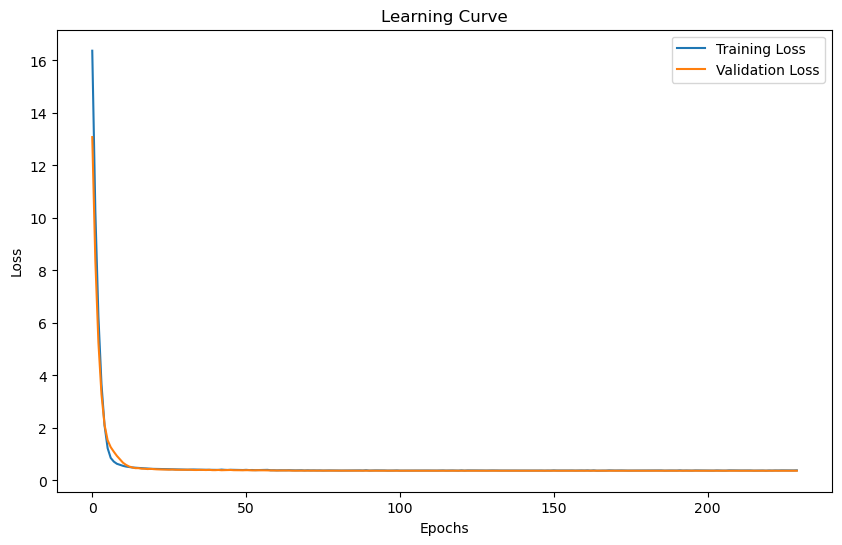

In [13]:
# MC Dropout function for prediction with uncertainty
def predict_with_uncertainty(model, X, n_iter=1000):
    """
    Perform MC Dropout predictions with TensorFlow 2.x.
    
    Args:
    - model: The Keras model with dropout layers.
    - X: Input data to make predictions on.
    - n_iter: Number of forward passes to perform.
    
    Returns:
    - mean_preds: Mean predictions.
    - uncertainty: Standard deviation of predictions (uncertainty).
    """
    
    # Perform n_iter forward passes and collect the predictions
    preds = [model(X, training=True) for _ in range(n_iter)]  # Dropout active during inference
    preds = np.array(preds)
    
    # Calculate mean and standard deviation of the predictions
    mean_preds = preds.mean(axis=0)
    uncertainty = preds.std(axis=0)
    
    return mean_preds, uncertainty

# Perform MC Dropout to predict with uncertainty
n_mc_samples = 1000  # Number of forward passes
mean_preds, uncertainty = predict_with_uncertainty(model, X_test_reshaped, n_iter=n_mc_samples)

# Reshape the mean predictions to match the shape used during scaling (num_samples, num_time_points * num_filters)
mean_preds_flat = mean_preds.reshape(mean_preds.shape[0], num_time_points * len(filter_order))  
# Invert the standardization for the mean predictions
mean_preds_inverted = target_scaler.inverse_transform(mean_preds_flat).reshape(mean_preds.shape[0], num_time_points, len(filter_order))

# Reshape uncertainty to match mean_preds_inverted shape
uncertainty_reshaped = uncertainty.reshape(uncertainty.shape[0], num_time_points, len(filter_order))
# Evaluate the model using the mean predictions
print(mean_preds_flat.flatten().shape)
test_mse_mc = mean_squared_error(y_test.flatten(), mean_preds_flat.flatten())
test_r2_mc = r2_score(y_test.flatten(), mean_preds_flat.flatten())
print(test_mse_mc.shape)
print(f'Test MSE with MC Dropout: {test_mse_mc:.4f}, Test R² with MC Dropout: {test_r2_mc:.4f}')
mae = np.mean(np.abs(y_test.flatten() - mean_preds_flat.flatten()))
print(mae)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

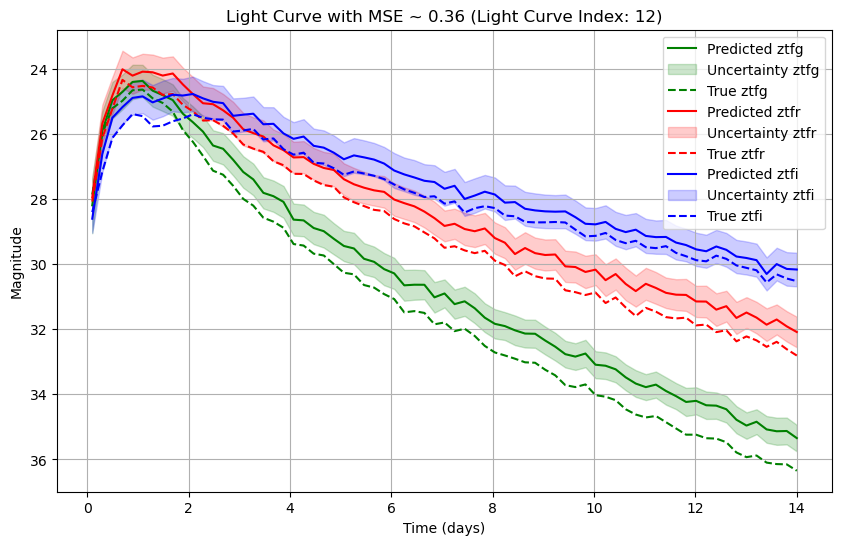

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Time points for plotting
time_points = np.tile(time_single, (X_test_reshaped.shape[0], 1))

# Invert the scaling for y_test to compare with predictions

y_test_inverted = target_scaler.inverse_transform(y_test.reshape(y_test.shape[0], -1)).reshape((y_test.shape[0], num_time_points, len(filter_order)))
mse_per_curve = np.mean((y_test_inverted - mean_preds_inverted) ** 2, axis=(1, 2))  # MSE for each light curve across all time points and filters

mse_target = 0.36
tolerance = 0.1  # Define a tolerance level to find light curves with MSE close to 3.6
selected_index = np.where(np.abs(mse_per_curve - mse_target) < tolerance)[0]  # Get the indices of the light curves that meet the condition

if len(selected_index) > 0:
    # Select the first light curve that matches the criteria
    example_idx = selected_index[0]

    # Step 3: Plot the selected light curve
    plt.figure(figsize=(10, 6))
    filter_names = ['ztfg', 'ztfr', 'ztfi']
    colors = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'blue'}

    # Plot the ZTFg, ZTFr, and ZTFi filters separately for the selected light curve
    mean_curve = mean_preds_inverted[example_idx]
    true_curve = y_test_inverted[example_idx]

    # Loop over each filter
    for i, filter_name in enumerate(filter_names):
        plt.plot(time_single, mean_curve[:, i], label=f'Predicted {filter_name}', color=colors[filter_name])
        plt.fill_between(time_single, 
                         mean_curve[:, i] - 5 * uncertainty_reshaped[example_idx, :, i], 
                         mean_curve[:, i] + 5 * uncertainty_reshaped[example_idx, :, i], 
                         color=colors[filter_name], alpha=0.2, label=f'Uncertainty {filter_name}')

        # Plot the true values for comparison
        plt.plot(time_single, true_curve[:, i], '--', color=colors[filter_name], label=f'True {filter_name}')

    # Add labels and title
    plt.xlabel('Time (days)')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()  # Invert the y-axis for magnitude, since lower magnitude means brighter
    plt.title(f'Light Curve with MSE ~ {mse_target} (Light Curve Index: {example_idx})')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"No light curve found with MSE close to {mse_target}.")

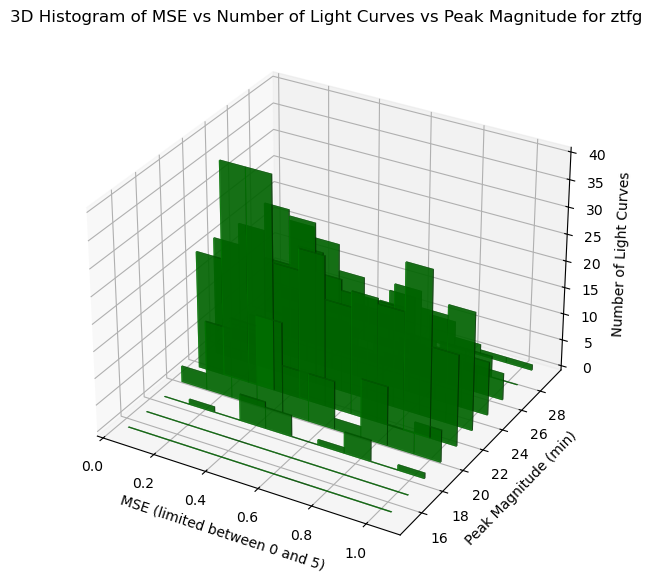

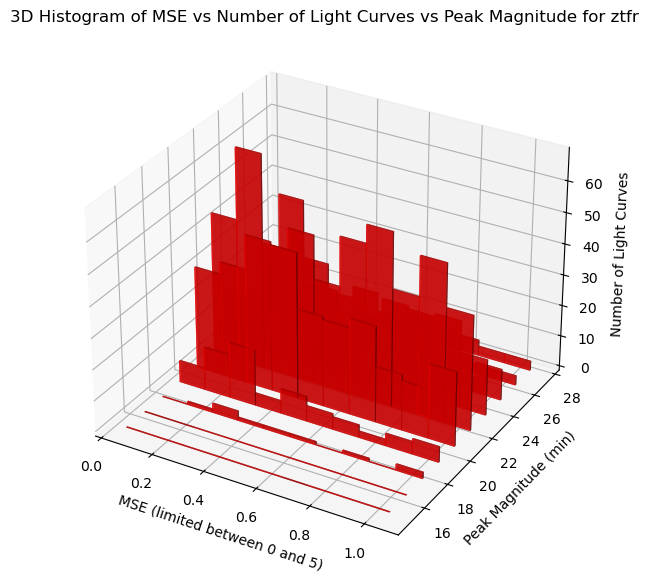

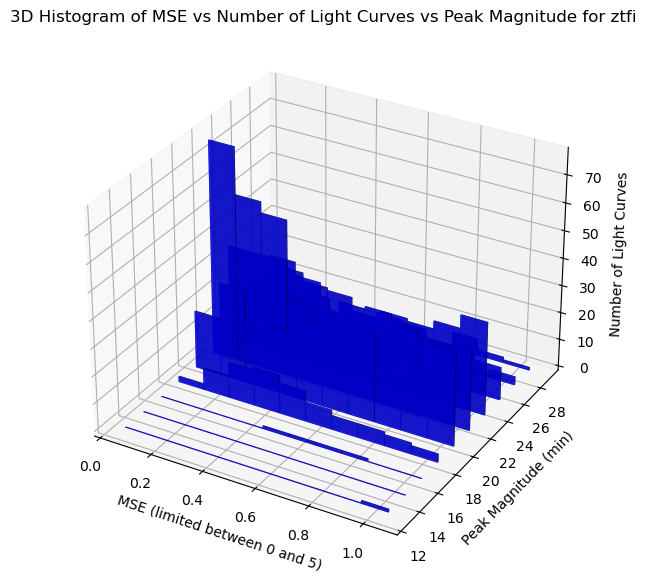

In [18]:
# Loop over each filter to calculate peak magnitudes and MSE per curve
for i, filter_name in enumerate(filter_names):
    # Calculate the minimum value (peak magnitude) for the current filter
    peak_magnitudes_filter = np.min(y_test_inverted[:, :, i], axis=1)  # Shape (num_samples,)
    
    # Calculate MSE for the current filter
    mse_per_curve_filter = np.mean((y_test_inverted[:, :, i] - mean_preds_inverted[:, :, i]) ** 2, axis=1)  # Shape (num_samples,)
    
    # Ensure both arrays have the same length
    assert peak_magnitudes_filter.shape == mse_per_curve_filter.shape, f"Shapes of peak magnitudes and MSE do not match for filter {filter_name}!"

    # Step 2: Create 3D histogram (binning the data) for each filter with MSE limited between 0 and 5
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot a 3D histogram for the current filter, now MSE on the x-axis and Peak Magnitude on the y-axis
    hist, xedges, yedges = np.histogram2d(mse_per_curve_filter, peak_magnitudes_filter, bins=10, range=[[0, 1], [np.min(peak_magnitudes_filter), np.max(peak_magnitudes_filter)]])

    # Construct arrays for the 3D histogram bars
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.5 * (xedges[1:] - xedges[:-1]),
                             yedges[:-1] + 0.5 * (yedges[1:] - yedges[:-1]), indexing="ij")

    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Set the width and depth for the bars
    dx = dy = 0.1 * np.ones_like(zpos)
    dz = hist.ravel()

    # Plot the bars
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color=colors[filter_names[i]], alpha=0.7)

    # Set labels and title
    ax.set_xlabel('MSE (limited between 0 and 5)')
    ax.set_ylabel('Peak Magnitude (min)')
    ax.set_zlabel('Number of Light Curves')
    ax.set_title(f'3D Histogram of MSE vs Number of Light Curves vs Peak Magnitude for {filter_name}')

    plt.show()

(2424, 71, 3)
(2424, 71, 3)


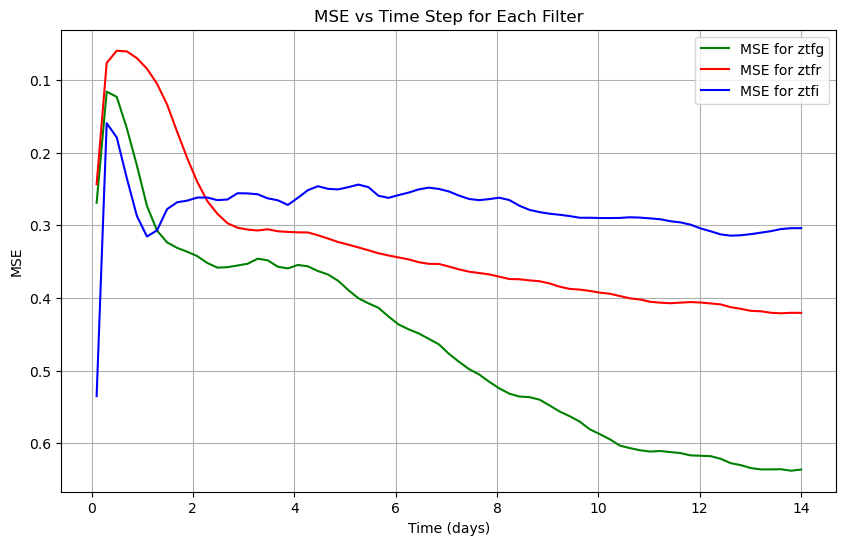

{'ztfg': 0.4657553395401175,
 'ztfr': 0.3287249589529709,
 'ztfi': 0.2768164991199842}

In [19]:
# Loop over each filter and compute MSE at each time step
mse_vs_time = {}
filter_names = ['ztfg', 'ztfr', 'ztfi']
colors = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'blue'}
y_test_reshaped = y_test.reshape(y_test.shape[0], num_time_points, len(filter_order)) 
print(y_test_reshaped.shape)
mean_preds_reshaped = mean_preds.reshape(mean_preds.shape[0], num_time_points, len(filter_order)) 
print(mean_preds_reshaped.shape)
for i, filter_name in enumerate(filter_names):
    # Calculate MSE at each time step (averaged across all light curves)
    mse_per_time_step = np.mean((y_test_reshaped[:,:,i] - mean_preds_reshaped[:,:,i]) ** 2, axis=0)  
    
    mse_vs_time[filter_name] = mse_per_time_step

plt.figure(figsize=(10, 6))

for filter_name in filter_names:
    plt.plot(time_single, mse_vs_time[filter_name], label=f'MSE for {filter_name}', color=colors[filter_name])

# Add labels and title
plt.xlabel('Time (days)')
plt.ylabel('MSE')
plt.title('MSE vs Time Step for Each Filter')
plt.legend()
plt.grid(True)
plt.gca().invert_yaxis() 
plt.show()
average_mse_per_filter = {filter_name: np.mean(mse_vs_time[filter_name]) for filter_name in filter_names}

average_mse_per_filter